# Constructing a WIMP Spectrum

The point of this notebook is to construct what a Si low-mass WIMP spectrum would look like at very low energy, with an HVeV detector biased to ~100V in the 1-5 e/h pair region. This is to illustrate how a variance in the nuclear recoil charge production can produce large effects. 

## Get the WIMP CDF

In [1]:
#get the stored CDF from a file
import dataPython as dp
import numpy as np
#data = dp.getXYZdata('WIMP_xsections/WIMP_Si_PDF_CDF_0.5GeV_1e-06keV_steps_fmt.txt')
data = dp.getXYZdata('WIMP_xsections/WIMP_Si_PDF_CDF_1GeV_5e-05keV_steps_fmt.txt')

#convert to numpy arrays
ekev = np.asarray(data['xx'])
pdf = np.asarray(data['yy'])
cdf = np.asarray(data['zz'])

print(data.keys())

dict_keys(['xx', 'yy', 'zz'])


In [2]:
#set up a plot 
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerLine2D
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

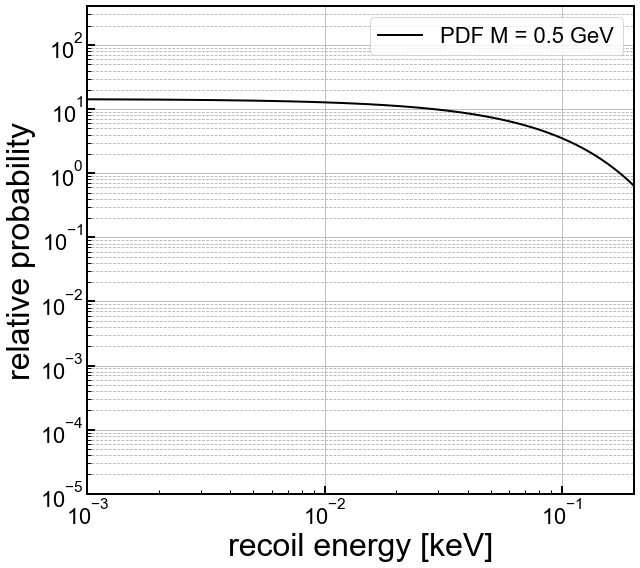

In [3]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

xmin = 0.001
xmax = 0.2
X = np.arange(xmin,xmax,0.01)

ax1.plot(ekev,pdf,'k-',label='PDF M = 0.5 GeV')


ymin=1e-5
ymax=400


ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('recoil energy [keV]',**axis_font)
ax1.set_ylabel('relative probability',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figures.png')
plt.show()

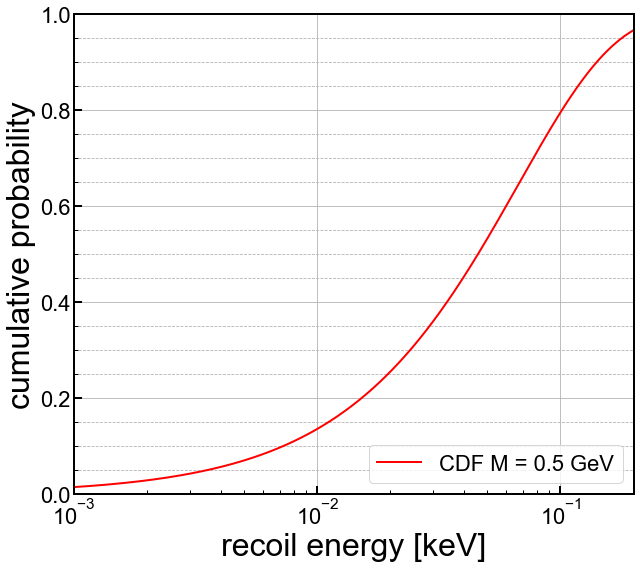

In [4]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

xmin = 0.001
xmax = 0.2
X = np.arange(xmin,xmax,0.01)

ax1.plot(ekev,cdf,'r-',label='CDF M = 0.5 GeV')


ymin=1e-5
ymax=1


ax1.set_yscale('linear')
ax1.set_xscale('log')
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('recoil energy [keV]',**axis_font)
ax1.set_ylabel('cumulative probability',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=4,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figures.png')
plt.show()

## Interpolate Inverted WIMP CDF and Generate Er

In [5]:
import scipy.interpolate as inter

#find first place cdf is unity
idx = np.arange(0,np.shape(cdf)[0])
print(idx)
idx_unity = idx[cdf>=1]
min_unity = np.min(idx_unity)
cdf_cut = cdf[idx<=min_unity]
ekev_cut = ekev[idx<=min_unity]

g = inter.InterpolatedUnivariateSpline (cdf_cut, ekev_cut, k=3)

[   0    1    2 ... 9997 9998 9999]


In [6]:
print(g(0.65))

0.06796898360512178


## Grab the Yield Model (DAMIC) and Generate N

In [7]:
import damic_y as dy 

#a spline extrapolation to DAMIC data
damic_y = dy.getDAMICy()
damic_yv = np.vectorize(damic_y) #vectorize it

In [9]:
#dream up some constants
F=1
eps = 3.8 #for silicon

Ntot = 100
u = np.random.uniform(0,1,(Ntot,))
Er = g(u)*1000 #use eV
print(Er[0:100])
Nav = Er*damic_yv(Er)*(1/eps)
print(Nav[0:100])

#get a bunch of recoil energies





[3.68413547e+01 6.99299283e+00 4.23217298e+01 5.19659454e+01
 2.27154971e+01 2.47298178e+02 2.97463389e+02 8.05305655e+01
 3.16868990e+01 5.96257182e+01 2.33823521e+01 7.29279354e+01
 3.90525582e+01 2.81748684e+01 3.43244516e+01 6.05983315e-01
 1.44000382e+02 4.48199503e+01 1.17200388e+02 8.89524843e+01
 7.34485141e+01 1.16127940e+01 1.03653875e+02 4.16556402e+01
 8.17878046e+01 2.14567341e+01 5.16763764e+01 1.26698935e+02
 6.46467276e+01 4.72074312e+00 7.30619740e+01 3.50388150e+01
 4.93653334e+00 9.16040480e+00 4.64907576e+01 4.95833214e+01
 7.29679595e+01 4.19200266e+01 4.34696205e+01 2.81907340e+01
 1.16407254e+02 3.43421998e+01 4.37321399e+01 2.38761708e+01
 9.58391323e+01 4.86319785e+01 1.12872810e+00 5.34781241e+01
 5.38807545e+01 2.01408841e+02 4.95017361e+01 2.19056805e+02
 1.86055067e+02 3.32649389e+01 3.43816362e+01 1.48849045e+01
 9.38348643e+00 2.78100883e+01 2.37460144e+01 3.02342372e+01
 1.04647404e+00 3.49042220e+01 7.57266270e+01 3.39997198e+01
 4.63946357e+01 5.627132